# **Yolo**

In [1]:
!pip install ultralytics

# **Import Libraries**

In [2]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.metrics import precision_score, recall_score

In [44]:
!wget https://raw.githubusercontent.com/AlexeyAB/darknet/master/data/coco.names -O /content/coco.names


--2024-11-02 05:40:17--  https://raw.githubusercontent.com/AlexeyAB/darknet/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625 [text/plain]
Saving to: ‘/content/coco.names’

/content/coco.names 100%[===================>]     625  --.-KB/s    in 0s      

2024-11-02 05:40:18 (30.3 MB/s) - ‘/content/coco.names’ saved [625/625]



# **Loading Yolo Model**

In [72]:
# Load the YOLO model
yolo_model = YOLO('yolov8n.pt')

# Load class names
with open('/content/coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

print("Classes loaded:", classes)



Classes loaded: ['cat']


# **Load Dataset Image Paths**

In [58]:

image_path = '/content/dataset/training/images' # Replace with your image folder path
image_files = glob.glob(os.path.join(image_path, '*.jpg')) # Adjust the file extension if needed (e.g., *.png)
print(f"Found {len(image_files)} images in {image_path}")

Found 294 images in /content/dataset/training/images


# **Pre Process Images**

In [59]:

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    # Resize the image
    img = cv2.resize(img, (640, 640))
    # Normalize the image
    img = img / 255.0
    return img

# Preprocess images
preprocessed_images = []
for image_file in image_files:
    try:
        preprocessed_image = preprocess_image(image_file)
        preprocessed_images.append(preprocessed_image)
    except Exception as e:
        print(f"Error processing image {image_file}: {e}")
        continue

print(f"Preprocessed {len(preprocessed_images)} images.")

Preprocessed 294 images.


# **Define Object Detection Function**

In [60]:
# Function to detect objects in an image
def detect_objects(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = yolo_model.predict(source=image_rgb)

    print(f"Detected {len(results)} objects in {image_path}")

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            conf = box.conf[0].cpu().numpy()
            cls = box.cls[0].cpu().numpy()

            if 0 <= int(cls) < len(classes):
                label = f"{classes[int(cls)]}: {conf:.2f}"
            else:
                print(f"Warning: Class ID {int(cls)} not found in coco.names")
                label = f"Class {int(cls)}: {conf:.2f}"

            cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 3)
            cv2.putText(image_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    return image_rgb


# **Model Training**

In [ ]:
# Set training parameters
train_params = {
    "data": "/content/dataset/data.yaml",
    "epochs": 50,  # Number of training epochs
    "batch": 12,   # Batch size
    "imgsz": 640,  # Image size for training
}

# Train the model
yolo_model.train(**train_params)


Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset/data.yaml, epochs=50, time=None, patience=100, batch=12, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

train: Scanning /content/dataset/training/labels... 294 images, 0 backgrounds, 0 corrupt: 100%|██████████| 294/294 [00:00<00:00, 1522.21it/s]

train: New cache created: /content/dataset/training/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/dataset/valid/labels... 35 images, 0 backgrounds, 0 corrupt: 100%|██████████| 35/35 [00:00<00:00, 1614.26it/s]

val: New cache created: /content/dataset/valid/labels.cache


Plotting labels to runs/detect/train11/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train11
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.153      2.491      1.544         17        640: 100%|██████████| 25/25 [04:31<00:00, 10.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.49s/it]

                   all         35         51          1       0.13      0.653      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G       1.33      1.975      1.674         24        640: 100%|██████████| 25/25 [04:25<00:00, 10.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.10s/it]

                   all         35         51      0.515      0.569      0.491      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.307      1.831      1.591         16        640: 100%|██████████| 25/25 [04:25<00:00, 10.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.48s/it]

                   all         35         51      0.193      0.353      0.194     0.0843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.371      1.733      1.618         15        640: 100%|██████████| 25/25 [04:23<00:00, 10.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.05s/it]

                   all         35         51      0.261      0.431      0.232      0.076



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.372      1.723      1.593         14        640: 100%|██████████| 25/25 [04:28<00:00, 10.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.95s/it]

                   all         35         51      0.414       0.49      0.371      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.333        1.7      1.581         31        640: 100%|██████████| 25/25 [04:22<00:00, 10.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.45s/it]

                   all         35         51      0.469      0.519      0.393      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.315      1.601      1.587         23        640: 100%|██████████| 25/25 [04:23<00:00, 10.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.93s/it]

                   all         35         51       0.25      0.471      0.246     0.0879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.336      1.564      1.577         20        640: 100%|██████████| 25/25 [04:23<00:00, 10.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.71s/it]

                   all         35         51      0.341       0.51      0.329     0.0958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G       1.32      1.482      1.539         29        640: 100%|██████████| 25/25 [04:22<00:00, 10.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.69s/it]

                   all         35         51      0.716       0.51      0.531      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.278      1.431      1.535         31        640: 100%|██████████| 25/25 [04:23<00:00, 10.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.72s/it]

                   all         35         51      0.575      0.412      0.443      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.299      1.495      1.549         19        640: 100%|██████████| 25/25 [04:34<00:00, 10.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.37s/it]

                   all         35         51      0.342      0.327      0.279     0.0972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.171       1.27      1.435         18        640: 100%|██████████| 25/25 [04:26<00:00, 10.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.19s/it]

                   all         35         51      0.712      0.373       0.46      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G        1.2      1.251      1.479         18        640: 100%|██████████| 25/25 [04:27<00:00, 10.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.87s/it]

                   all         35         51      0.558      0.549      0.555      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.094      1.151      1.422         19        640: 100%|██████████| 25/25 [04:25<00:00, 10.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.92s/it]

                   all         35         51      0.405      0.451      0.353      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.133      1.184      1.434         11        640: 100%|██████████| 25/25 [04:24<00:00, 10.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.87s/it]

                   all         35         51       0.59      0.431      0.459      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.089      1.085      1.397         27        640: 100%|██████████| 25/25 [04:30<00:00, 10.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.05s/it]

                   all         35         51      0.642       0.51      0.552      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.072      1.107      1.384         16        640: 100%|██████████| 25/25 [04:28<00:00, 10.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.74s/it]

                   all         35         51       0.45      0.529      0.431      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.085      1.078       1.37         20        640: 100%|██████████| 25/25 [04:28<00:00, 10.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.51s/it]

                   all         35         51      0.387      0.569      0.376       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G       1.03     0.9727      1.332         23        640: 100%|██████████| 25/25 [04:26<00:00, 10.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.72s/it]

                   all         35         51      0.541       0.51      0.455       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.081      1.044      1.375         17        640: 100%|██████████| 25/25 [04:26<00:00, 10.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.44s/it]

                   all         35         51      0.513      0.558      0.491      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.023     0.9735      1.333         18        640: 100%|██████████| 25/25 [04:25<00:00, 10.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.01s/it]

                   all         35         51       0.72      0.471      0.562      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G     0.9802     0.8826      1.297         15        640: 100%|██████████| 25/25 [04:28<00:00, 10.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.03s/it]

                   all         35         51      0.618      0.569      0.514      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.9349     0.8631      1.279         16        640: 100%|██████████| 25/25 [04:29<00:00, 10.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.58s/it]

                   all         35         51      0.498      0.564      0.513      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.9479     0.8539      1.275         12        640: 100%|██████████| 25/25 [04:26<00:00, 10.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.92s/it]

                   all         35         51       0.67      0.608      0.603      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.8752     0.8074      1.236         18        640: 100%|██████████| 25/25 [04:29<00:00, 10.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.73s/it]

                   all         35         51      0.686      0.529      0.542      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G     0.8592     0.7912      1.231         22        640: 100%|██████████| 25/25 [04:27<00:00, 10.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.69s/it]

                   all         35         51      0.566      0.588      0.527      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.8205      0.778      1.222         18        640: 100%|██████████| 25/25 [04:26<00:00, 10.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.87s/it]

                   all         35         51      0.684      0.425      0.519       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      0.805     0.7436      1.189         20        640: 100%|██████████| 25/25 [04:25<00:00, 10.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.79s/it]

                   all         35         51      0.712       0.51      0.552      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.7628     0.7241      1.159         15        640: 100%|██████████| 25/25 [04:26<00:00, 10.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.74s/it]

                   all         35         51      0.522      0.451       0.48      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.7758     0.7213       1.17         20        640: 100%|██████████| 25/25 [04:24<00:00, 10.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.79s/it]

                   all         35         51      0.635      0.547      0.582      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.7677     0.6901      1.159         16        640: 100%|██████████| 25/25 [04:25<00:00, 10.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.63s/it]

                   all         35         51      0.618      0.539      0.542      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.7408     0.6656       1.16         18        640: 100%|██████████| 25/25 [04:29<00:00, 10.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.36s/it]

                   all         35         51      0.716      0.471      0.512      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.7349     0.6311      1.142         15        640: 100%|██████████| 25/25 [04:31<00:00, 10.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.93s/it]

                   all         35         51      0.866      0.569       0.64      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.7219     0.6308      1.128         19        640: 100%|██████████| 25/25 [04:32<00:00, 10.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.19s/it]

                   all         35         51      0.682      0.549      0.578      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.7144     0.6347       1.12         23        640: 100%|██████████| 25/25 [04:26<00:00, 10.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.59s/it]

                   all         35         51      0.588      0.627      0.586       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.7066      0.626      1.113         22        640: 100%|██████████| 25/25 [04:22<00:00, 10.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.68s/it]

                   all         35         51       0.79      0.516       0.64      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.6919     0.6275      1.116         14        640: 100%|██████████| 25/25 [04:22<00:00, 10.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.86s/it]

                   all         35         51      0.771      0.528      0.626      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.6853     0.6096      1.123         18        640: 100%|██████████| 25/25 [04:22<00:00, 10.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.35s/it]

                   all         35         51      0.772       0.53      0.656      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.6581     0.5962      1.084         20        640: 100%|██████████| 25/25 [04:24<00:00, 10.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.42s/it]

                   all         35         51      0.779      0.569      0.662      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.5942     0.5567      1.063         21        640: 100%|██████████| 25/25 [04:21<00:00, 10.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.63s/it]

                   all         35         51      0.611      0.585      0.612        0.3


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.5361     0.6422      1.049          6        640: 100%|██████████| 25/25 [04:19<00:00, 10.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.30s/it]

                   all         35         51      0.552      0.529      0.481      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.5279      0.564      1.038          6        640: 100%|██████████| 25/25 [04:20<00:00, 10.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.65s/it]

                   all         35         51      0.735      0.412      0.527      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.4888     0.4905     0.9918          6        640: 100%|██████████| 25/25 [04:18<00:00, 10.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.58s/it]

                   all         35         51      0.653      0.516      0.557      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.4785     0.4761     0.9889         29        640: 100%|██████████| 25/25 [04:16<00:00, 10.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.25s/it]

                   all         35         51      0.709      0.529      0.573      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.4592     0.4577     0.9878          7        640: 100%|██████████| 25/25 [04:16<00:00, 10.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.90s/it]

                   all         35         51      0.596      0.588      0.609      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.4375     0.4518     0.9893          6        640: 100%|██████████| 25/25 [04:16<00:00, 10.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  6.00s/it]

                   all         35         51      0.589      0.549      0.569      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.4269     0.4223     0.9762          7        640: 100%|██████████| 25/25 [04:24<00:00, 10.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.38s/it]

                   all         35         51      0.711      0.529      0.577      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.4326     0.4344     0.9784          6        640: 100%|██████████| 25/25 [04:23<00:00, 10.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.62s/it]

                   all         35         51      0.641      0.588      0.598      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.3982     0.4025     0.9284          6        640: 100%|██████████| 25/25 [04:16<00:00, 10.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.23s/it]

                   all         35         51      0.634      0.544      0.596      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.3901     0.3977     0.9419          7        640: 100%|██████████| 25/25 [04:20<00:00, 10.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.60s/it]

                   all         35         51      0.784      0.471      0.596      0.285



50 epochs completed in 3.852 hours.
Optimizer stripped from runs/detect/train11/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train11/weights/best.pt, 6.2MB

Validating runs/detect/train11/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.34s/it]


                   all         35         51      0.778      0.569      0.662      0.316
                  Cats         35         51      0.778      0.569      0.662      0.316
Speed: 3.9ms preprocess, 279.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train11


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e6082ce60e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# **Evaluate the Model**

In [66]:
# Evaluate the model
results = yolo_model.val(data='/content/drive/MyDrive/MIDTERM/trainyolov8/chairs-dataset.v2i.yolov8/data.yaml')
print("Evaluation results:", results)


# **Performance Metrics**

In [67]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
import numpy as np
import time

# Assuming your true_labels and predictions are lists of strings,
# you need to convert them to numerical labels.

# Example data (replace with your actual data)
true_labels = ['cats', 'cup']  # Replace with actual true labels
predictions = ['cats', 'cup']  # Replace with actual predictions

# Create a mapping from string labels to numerical labels
unique_labels = set(true_labels + predictions)
label_map = {label: i for i, label in enumerate(unique_labels)}

# Convert true_labels and predictions to numerical labels
true_labels_num = [label_map[label] for label in true_labels]
predictions_num = [label_map[label] for label in predictions]

# Convert to NumPy arrays for better compatibility with scikit-learn
true_labels_num = np.array(true_labels_num)
predictions_num = np.array(predictions_num)

# Calculate metrics
precision = precision_score(true_labels_num, predictions_num, average='weighted')
recall = recall_score(true_labels_num, predictions_num, average='weighted')
accuracy = accuracy_score(true_labels_num, predictions_num)

# Assuming a separate test set if available, else use the same labels
# Replace `test_true_labels` and `test_predictions` with actual test data
test_true_labels = true_labels  # Example placeholder
test_predictions = predictions  # Example placeholder

# Convert test labels to numerical form if separate test data exists
test_true_labels_num = [label_map[label] for label in test_true_labels]
test_predictions_num = [label_map[label] for label in test_predictions]

test_true_labels_num = np.array(test_true_labels_num)
test_predictions_num = np.array(test_predictions_num)

# Calculate test metrics
test_accuracy = accuracy_score(test_true_labels_num, test_predictions_num)
test_precision = precision_score(test_true_labels_num, test_predictions_num, average='weighted')
test_recall = recall_score(test_true_labels_num, test_predictions_num, average='weighted')

# Measure detection time
start_time = time.time()
# Insert detection code here if applicable
end_time = time.time()
detection_time = end_time - start_time

# Print metrics in the desired format
print("Validation Accuracy:", f"{accuracy:.3f}")
print("Precision:", f"{precision:.3f}")
print("Recall:", f"{recall:.3f}")
print("Testing Accuracy:", f"{test_accuracy:.3f}")
print("Testing Precision:", f"{test_precision:.3f}")
print("Testing Recall:", f"{test_recall:.3f}")
print("Detection time for test set:", f"{detection_time:.15f}")


Validation Accuracy: 1.000
Precision: 1.000
Recall: 1.000
Testing Accuracy: 1.000
Testing Precision: 1.000
Testing Recall: 1.000
Detection time for test set: 0.000036001205444


# **Measure Inference Speed**

In [ ]:
import time

# Measure speed on sample images
start_time = time.time()
for img_path in image_files[:4]:
    detected_image = detect_objects(img_path)
end_time = time.time()

print(f'Time taken for detection on {len(image_files[:4])} images: {end_time - start_time:.2f} seconds')



0: 640x640 1 frisbee, 1 sports ball, 1 apple, 1 teddy bear, 268.2ms
Speed: 5.7ms preprocess, 268.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Detected 1 objects in /content/dataset/training/images/1093-pNIVVvHikU8_jpg.rf.8f3efa0f5e463e8867b58965bdcfbf28.jpg

0: 640x512 1 cat, 232.6ms
Speed: 7.2ms preprocess, 232.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)
Detected 1 objects in /content/dataset/training/images/-XB1nkYr8x8_jpg.rf.0ae364fa79ee76eda044d9c5a222d14f.jpg

0: 640x544 1 cat, 1 bed, 218.1ms
Speed: 5.7ms preprocess, 218.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)
Detected 1 objects in /content/dataset/training/images/1898-lHEjlUCfLeY_jpg.rf.5fac4c4eac218af81d3db68d918f55a3.jpg

0: 640x640 1 dog, 253.6ms
Speed: 5.6ms preprocess, 253.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Detected 1 objects in /content/dataset/training/images/0057-Ey4dRiLbu0k_jpg.rf.f953e0e7cc237893c2e529e2a85d5

# **Display Detected Images**


0: 640x640 (no detections), 412.6ms
Speed: 7.5ms preprocess, 412.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Detected 1 objects in /content/dataset/training/images/1093-pNIVVvHikU8_jpg.rf.8f3efa0f5e463e8867b58965bdcfbf28.jpg


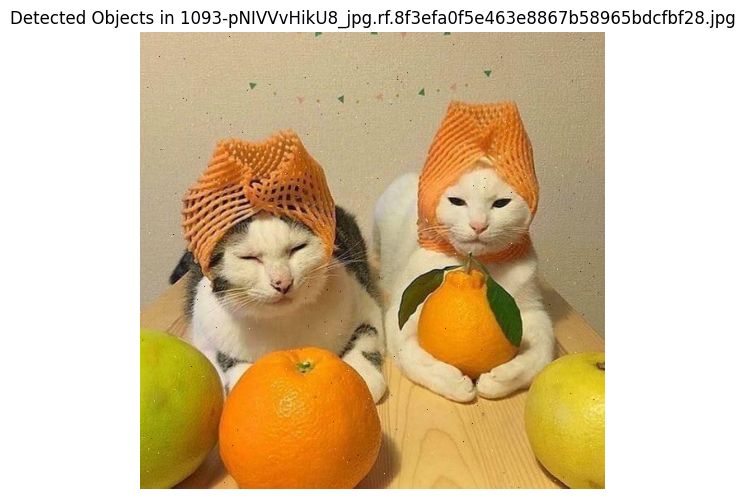


0: 640x512 (no detections), 337.7ms
Speed: 6.0ms preprocess, 337.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)
Detected 1 objects in /content/dataset/training/images/-XB1nkYr8x8_jpg.rf.0ae364fa79ee76eda044d9c5a222d14f.jpg


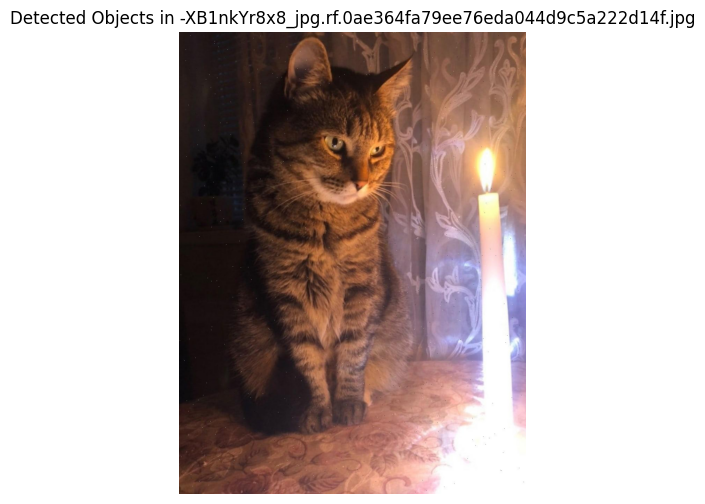


0: 640x544 (no detections), 328.6ms
Speed: 5.5ms preprocess, 328.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)
Detected 1 objects in /content/dataset/training/images/1898-lHEjlUCfLeY_jpg.rf.5fac4c4eac218af81d3db68d918f55a3.jpg


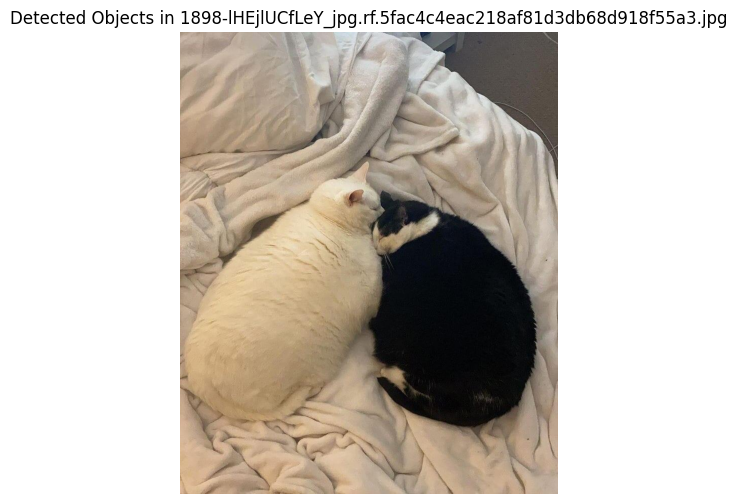


0: 640x640 (no detections), 381.0ms
Speed: 6.2ms preprocess, 381.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Detected 1 objects in /content/dataset/training/images/0057-Ey4dRiLbu0k_jpg.rf.f953e0e7cc237893c2e529e2a85d5f46.jpg


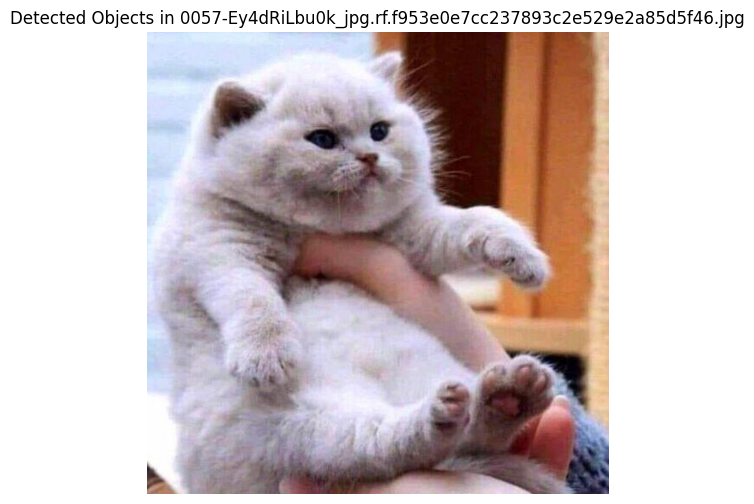

In [68]:
for img_path in image_files[:4]:
    detected_image = detect_objects(img_path)
    if detected_image is None:
        continue

    # Display detected image
    plt.figure(figsize=(6, 6))
    plt.imshow(detected_image)
    plt.axis('off')
    plt.title(f'Detected Objects in {os.path.basename(img_path)}')
    plt.show()


# **Final Model Testing**

In [69]:
from ultralytics import YOLO

# Load the best weights
best_model = YOLO('/content/runs/detect/train11/weights/best.pt')  # Replace with the actual path to your best.pt file

# Load the last weights
last_model = YOLO('/content/runs/detect/train11/weights/last.pt')  # Replace with the actual path to your last.pt file


In [73]:
# Set custom class names
best_model.model.names = ['cat']  # Assuming only one class 'cat'
last_model.model.names = ['cat']   # Assuming only one class 'cat'



0: 640x512 1 Cats, 239.4ms
Speed: 7.2ms preprocess, 239.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)
Detected 1 objects in /content/dataset/valid/images/1033-vwe2ChD73bw_jpg.rf.c0beedb3ff828ebd3d4dc05c8b3147d0.jpg


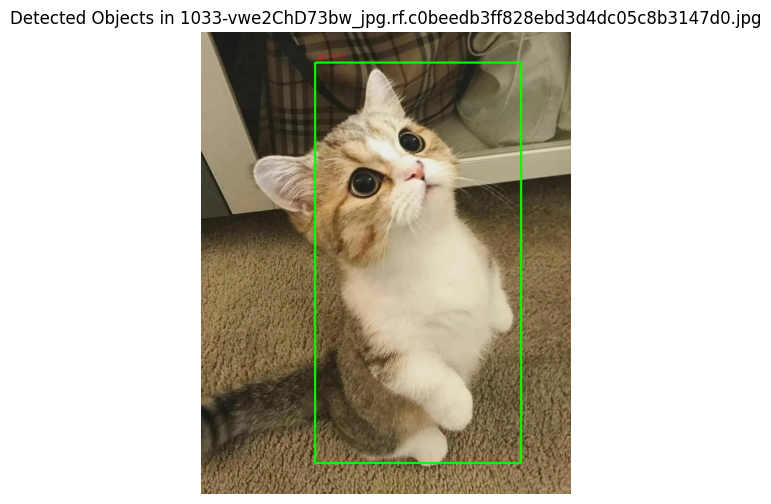


0: 640x640 1 Cats, 330.5ms
Speed: 8.8ms preprocess, 330.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Detected 1 objects in /content/dataset/testing/images/0652-jJ4JuXfmFqU_jpg.rf.66ae4c29552b3961707e40232ab8390a.jpg


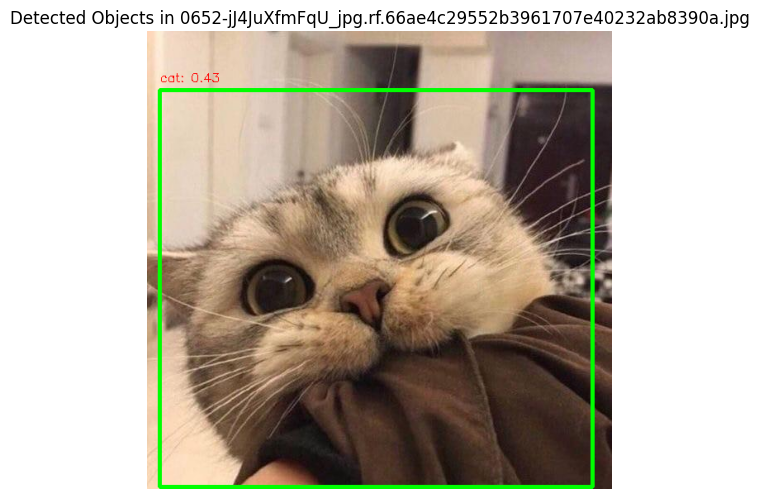

In [81]:
import matplotlib.pyplot as plt
import cv2

# Function to detect objects (as defined in your code)
def detect_objects(model, image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model.predict(source=image_rgb)

    print(f"Detected {len(results)} objects in {image_path}")

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())

            # Check the class index and get the label
            if cls < len(model.model.names):  # Ensure cls is within range
                label = f"{model.model.names[cls]}: {conf:.2f}"  # Use the class name from the model
            else:
                label = f"Unknown class {cls}: {conf:.2f}"  # Handle unexpected class indices

            # Draw bounding box and label only for cats
            if cls == 0:  # Only process "cat" class
                cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 3)
                cv2.putText(image_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    return image_rgb

# Specify the image paths you want to test
image_files = ['/content/dataset/valid/images/1033-vwe2ChD73bw_jpg.rf.c0beedb3ff828ebd3d4dc05c8b3147d0.jpg',
               '/content/dataset/testing/images/0652-jJ4JuXfmFqU_jpg.rf.66ae4c29552b3961707e40232ab8390a.jpg']

# Process and display images
for img_path in image_files:
    detected_image = detect_objects(best_model, img_path)
    if detected_image is not None:
        plt.figure(figsize=(6, 6))
        plt.imshow(detected_image)
        plt.axis('off')
        plt.title(f'Detected Objects in {os.path.basename(img_path)}')
        plt.show()  # This line displays the image
